In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

%matplotlib inline

#  Load, Clean, and Merge Datasets

In [102]:
#load two csv files with data on vaccine safety perception and perceived corruption
#only load columns with country name and 2015 because 2015 is only year that contains data 
#from both datasets
vaccines = pd.read_csv("vccin_sfty_dag.csv", usecols=['country','2015'])
corruption = pd.read_csv("corruption_perception_index_cpi.csv", usecols=['country','2015'])

In [103]:
#higher the proportion, the larger the vaccine hesistancy
vaccines.head()

,country,2015
0,Afghanistan,8.5
1,Albania,NaN
2,UAE,NaN
3,Argentina,1.2
4,Armenia,21.6


In [104]:
#lower value means more perceived corruption
corruption.head()

,country,2015
0,Afghanistan,11.0
1,Angola,15.0
2,Albania,36.0
3,UAE,70.0
4,Argentina,32.0


In [105]:
#rename columns to identify data and prepare to join dfs
vaccines.rename(columns = {"2015": "vaccine_unsafe"}, inplace = True)
corruption.rename(columns = {"2015":"perceived_corruption"}, inplace = True)

In [106]:
#new dataframe merging vaccine and corruption dataframes
data_df = vaccines.merge(corruption, on = 'country')

In [107]:
#get rid of rows with NaN values because they are unfit for analysis
data_df.dropna(inplace = True)

In [108]:
#use additional df with region names to do further sub-group analyses on our data
regions = pd.read_csv('continents2.csv', usecols = ['name', 'region', 'sub-region'])

In [109]:
#rename column to use .merge on old df
regions.rename(columns = {'name':'country'}, inplace = True)

In [110]:
regions.head()

,country,region,sub-region
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [111]:
#final df with vaccine, corruption, and region data
df = data_df.merge(regions, on='country')

In [112]:
df.head()

,country,vaccine_unsafe,perceived_corruption,region,sub-region
0,Afghanistan,8.5,11.0,Asia,Southern Asia
1,Argentina,1.2,32.0,Americas,Latin America and the Caribbean
2,Armenia,21.6,35.0,Asia,Western Asia
3,Australia,5.4,79.0,Oceania,Australia and New Zealand
4,Austria,14.6,76.0,Europe,Western Europe


# Statistical Analysis - Worldwide

## Scatterplot

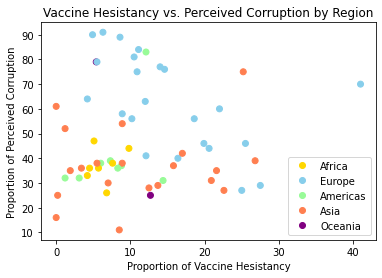

In [113]:
colors = df.region.map({'Africa': 'gold', 
                        'Europe': 'skyblue', 
                        'Americas': 'palegreen', 
                        'Asia': 'coral', 
                        'Oceania': 'purple'})


data = plt.scatter(data = df, x= 'vaccine_unsafe', 
                      y= 'perceived_corruption', c = colors)
plt.title("Vaccine Hesistancy vs. Perceived Corruption by Region")
plt.xlabel("Proportion of Vaccine Hesistancy")
plt.ylabel("Proportion of Perceived Corruption")

#create legend
#code credit for legend: 
#https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary

#redefine dictionary to use for legend values
color_legend = {'Africa': 'gold', 
                        'Europe': 'skyblue', 
                        'Americas': 'palegreen', 
                        'Asia': 'coral', 
                        'Oceania': 'purple'}

#create fake lines to use in .legend() function
markers = [plt.Line2D([0,0], [0,0], color=color, marker = "o", 
                      linestyle = "") for color in color_legend.values()]
plt.legend(markers, color_legend.keys(), numpoints = 1)

## Correlations

In [114]:
pearsonr(df["vaccine_unsafe"], df["perceived_corruption"])

(0.038298956557929587, 0.7714119937673969)

The correlation coefficient is 0.0383, suggesting nearly no relationship between the two variables. 
The p-value is 0.77, which is less than 0.05, therefore, these results are not statistically significant

# Statistical Analysis - Grouped By Sub-Region

In [115]:
#function to calculate correlation and p-value for each sub-region, output as
#dataframe
def calculate_corr(dataframe):
    
    #store each corr in a dict entry to later convert into df to display results
    corr_dict = {}
    
    #loop through each subregion in list of all unique subregions in dataframe
    for subregion in dataframe['sub-region'].unique():
        #create a dataframe for specific subregion
        data = dataframe[dataframe['sub-region'] == subregion]
        
        #exclude subregions with insufficient data amount
        if len(data) > 1:
        #calculate correlation and p-value
            corr = pearsonr(data["vaccine_unsafe"], data["perceived_corruption"])
        
        #add corr to dictionary
        corr_dict[subregion] = [corr[0], corr[1]]
 
    
    #convert dict to df to display results neatly
    corr_df = pd.DataFrame.from_dict(corr_dict)
    
    #rename rows for clarity
    corr_df.index = ["Correlation Coefficient", "p-Value"]
    
    return corr_df

In [117]:
calculate_corr(df)

,Southern Asia,Latin America and the Caribbean,Western Asia,Australia and New Zealand,Western Europe,Eastern Europe,Northern America,Eastern Asia,Northern Europe,Northern Africa,Southern Europe,Sub-Saharan Africa,South-eastern Asia,Melanesia
Correlation Coefficient,0.063199,0.03104,-0.243147,-0.243147,-0.865591,-0.842470,-0.842470,0.157242,-0.898846,0.923396,-0.579171,0.20881,-0.821939,-0.821939
p-Value,0.919587,0.94733,0.599313,0.599313,0.057946,0.035269,0.035269,0.842758,0.014831,0.250803,0.228382,0.79119,0.178061,0.178061
